# Exemple de détection changement

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Importation des bibliothèques nécessaires

In [3]:
! pip install rasterio

In [4]:
import os
import numpy as np
import rasterio
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Charger le modèle

In [6]:
# ---------- Paramètres ----------
patch_size = (1072, 656)
num_classes = 10
model_path = r'D:\deep_learning\teledetection_PFE\Application_detection_changement\unet2_72_best_model.h5'
# ---------- Charger le modèle ----------
model = load_model(model_path)

# Chargement et Prétraitement des images

In [7]:
def preprocess_image(img_path, target_size=(1072, 656)):
    with rasterio.open(img_path) as src:
        b2 = src.read(1).astype(np.float32)
        b3 = src.read(2).astype(np.float32)
        b4 = src.read(3).astype(np.float32)
        b8 = src.read(4).astype(np.float32)
        b11 = src.read(5).astype(np.float32)

        b2 = np.nan_to_num(b2, nan=0)
        b3 = np.nan_to_num(b3, nan=0)
        b4 = np.nan_to_num(b4, nan=0)
        b8 = np.nan_to_num(b8, nan=0)
        b11 = np.nan_to_num(b11, nan=0)

        ndvi = (b8 - b4) / (b8 + b4 + 1e-10)
        ndwi = (b3 - b8) / (b3 + b8 + 1e-10)
        ndbi = (b11 - b8) / (b11 + b8 + 1e-10)

        image = np.dstack((b4, b3, b2, b8, b11, ndvi, ndwi, ndbi))
        # target_size = (height, width)
        resized = cv2.resize(image, (target_size[1], target_size[0]), interpolation=cv2.INTER_LINEAR)
    return resized

# ---------- Découpage en patches ----------
def image_to_patches(image, patch_size):
    h, w, c = image.shape
    ph, pw = patch_size
    patches = []
    positions = []

    for i in range(0, h, ph):
        for j in range(0, w, pw):
            patch = image[i:i+ph, j:j+pw, :]
            if patch.shape[0] == ph and patch.shape[1] == pw:
                patches.append(patch)
                positions.append((i, j))
    return np.array(patches), positions

# ---------- Reconstruction des masques ----------
def reconstruct_mask(pred_patches, positions, image_shape, patch_size):
    full_mask = np.zeros(image_shape[:2], dtype=np.uint8)
    ph, pw = patch_size

    for pred, (i, j) in zip(pred_patches, positions):
        full_mask[i:i+ph, j:j+pw] = np.argmax(pred, axis=-1)
    return full_mask

# ---------- Prédire le masque pour une image entière ----------
def predict_mask_for_image(image_path):
    image = preprocess_image(image_path)
    patches, positions = image_to_patches(image, patch_size)
    predictions = []

    for patch in tqdm(patches, desc="Prédiction des patches"):
        patch_input = np.expand_dims(patch, axis=0)
        pred = model.predict(patch_input, verbose=0)
        predictions.append(pred[0])

    mask = reconstruct_mask(predictions, positions, image.shape, patch_size)
    return mask
# ---------- Afficher les masks et images  ----------
def show_image_and_mask(image_path, predicted_mask, title):
    import matplotlib.patches as mpatches
    dw_palette = [
        '#419bdf', 
        '#397d49',  
        '#88b053', 
        '#7a87c6', 
        '#e49635',  
        '#dfc35a', 
        '#c4281b', 
        '#a59b8f',  
        '#b39fe1',  
        '#000000'   
    ]
    dw_labels = [
        "0: Eau",
        "1: Arbres",
        "2: Herbe",
        "3: Végétation inondée",
        "4: Cultures",
        "5: Arbustes",
        "6: Construit",
        "7: Sol nu",
        "8: Neige / Glace",
        "9: Fond (Background)"
    ]

    # Prétraitement image
    image = preprocess_image(image_path)
    print("✅ Shape de l’image :", image.shape)

    rgb_image = image[:, :, [2, 1, 0]]
    rgb_image = (rgb_image - rgb_image.min()) / (rgb_image.max() - rgb_image.min() + 1e-10)

    # Créer la figure avec 3 zones : RGB | Mask | Légende
    fig = plt.figure(figsize=(16, 6))

    # Image RGB
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(rgb_image)
    ax1.set_title(f"{title} - Image RGB")
    ax1.axis('off')

    # Masque prédictif
    ax2 = fig.add_subplot(1, 3, 2)
    cmap = ListedColormap(dw_palette)
    im = ax2.imshow(predicted_mask, cmap=cmap, vmin=0, vmax=len(dw_palette) - 1)
    ax2.set_title(f"{title} - Masque Prédit")
    ax2.axis('off')

    # Légende à droite
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.axis('off')
    legend_patches = [
        mpatches.Patch(color=dw_palette[i], label=dw_labels[i]) for i in range(len(dw_labels))
    ]
    ax3.legend(handles=legend_patches, loc='center left', fontsize='small', frameon=False)

    plt.tight_layout()
    plt.show()

# Détection de changement 

On définit la fonction qui compare les masques des deux dates.

In [8]:
def detect_change(mask1, mask2):
    change_map = np.zeros_like(mask1)
    
    # Urbanisation
    change_map[np.logical_and(mask1 == 1, mask2 == 6)] = 0
    change_map[np.logical_and(mask1 == 5, mask2 == 6)] = 0  

    # Artificialisation
    change_map[np.logical_and(mask1 == 4, mask2 == 6)] = 1

    # Mise en culture
    change_map[np.logical_and(mask1 == 7, mask2 == 4)] = 2
    change_map[np.logical_and(mask1 == 5, mask2 == 4)] = 2  

    # Abandon de culture
    change_map[np.logical_and(mask1 == 4, mask2 == 7)] = 3
    change_map[np.logical_and(mask1 == 4, mask2 == 5)] = 3  

    # Déforestation
    change_map[np.logical_and(mask1 == 1, mask2 == 7)] = 4
    change_map[np.logical_and(mask1 == 1, mask2 == 4)] = 4
    change_map[np.logical_and(mask1 == 1, mask2 == 5)] = 4  

    # Assèchement
    change_map[np.logical_and(mask1 == 0, mask2 == 7)] = 5

    # Inondation
    change_map[np.logical_and(mask1 == 7, mask2 == 0)] = 6

    # Forestation
    change_map[np.logical_and(mask1 == 4, mask2 == 1)] = 7
    change_map[np.logical_and(mask1 == 7, mask2 == 1)] = 7

    # Pas de changement
    change_map[np.logical_and(mask1 == mask2, change_map == 0)] = 8

    # Non classifié (reste)
    change_map[np.logical_and(mask1 != mask2, change_map == 0)] = 9

    # Background
    change_map[np.logical_or(mask1 == 9, mask2 == 9)] = 10

    return change_map

## On fournin les 2 images

In [13]:
img_path1 = r"Sentinel2_roi_barage_2017_Fall_norm.tif"
img_path2 = r"Sentinel2_roi_barage_2019_Fall_norm.tif"

In [20]:
# img_path1 = "/kaggle/input/application-change-detection2/Images/GEE_Exports_Images_norm/Sentinel2_roi_barage_2018_Spring_norm.tif"
# img_path2 = "/kaggle/input/application-change-detection2/Images/GEE_Exports_Images_norm/Sentinel2_roi_barage_2022_Spring_norm.tif"

## Prédiction des deux années 

In [14]:
print("Prédiction de l’année 1...")
mask1 = predict_mask_for_image(img_path1)

print("Prédiction de l’année 2...")
mask2 = predict_mask_for_image(img_path2)
print("Shape du masque de l’image 1 :", mask1.shape)
print("Shape du masque de l’image 2 :", mask2.shape)

Prédiction de l’année 1...


Prédiction des patches: 100%|██████████| 1/1 [05:46<00:00, 346.97s/it]


Prédiction de l’année 2...


Prédiction des patches: 100%|██████████| 1/1 [07:15<00:00, 435.43s/it]

Shape du masque de l’image 1 : (1072, 656)
Shape du masque de l’image 2 : (1072, 656)


## Affichage des prédictions

✅ Shape de l’image : (1072, 656, 8)


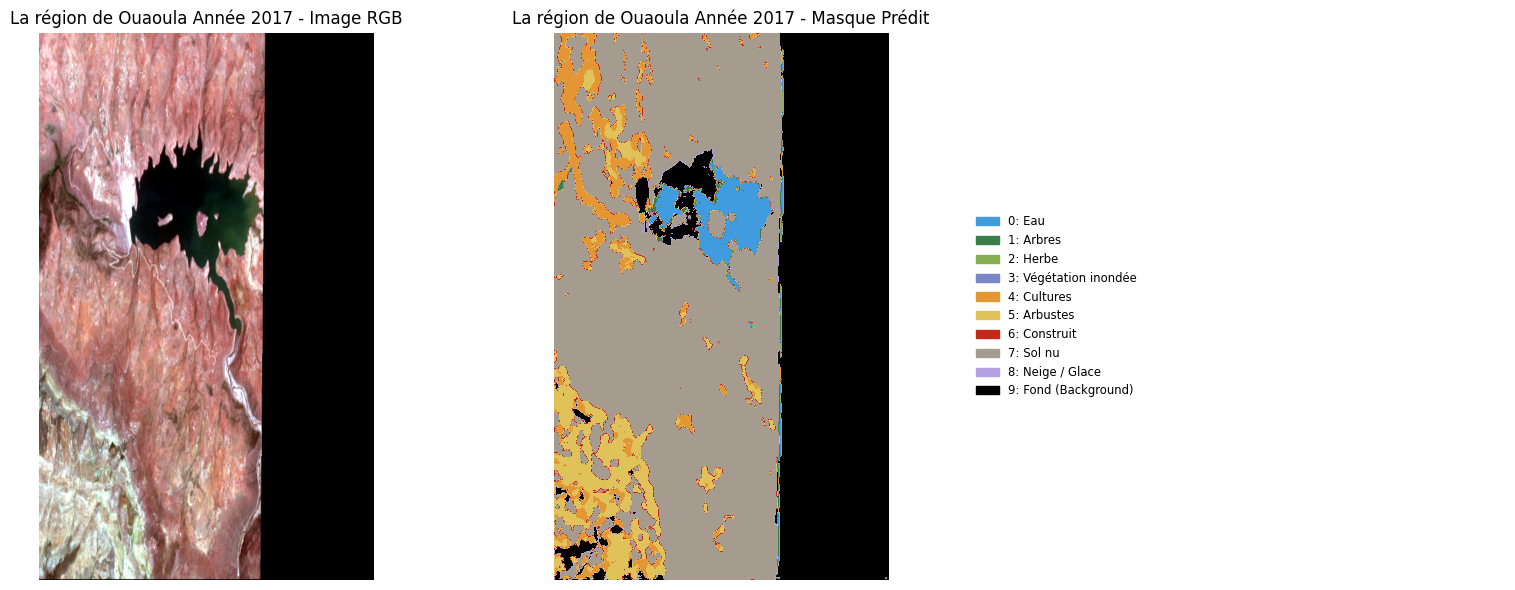

✅ Shape de l’image : (1072, 656, 8)


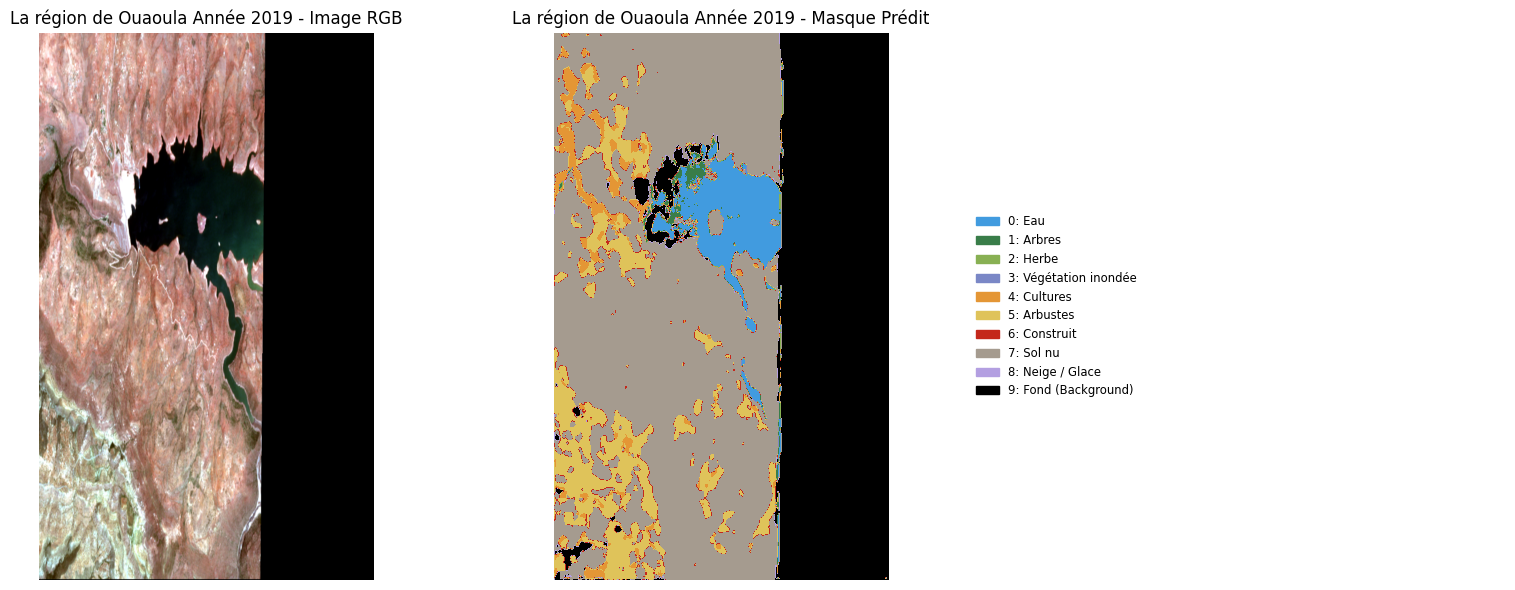

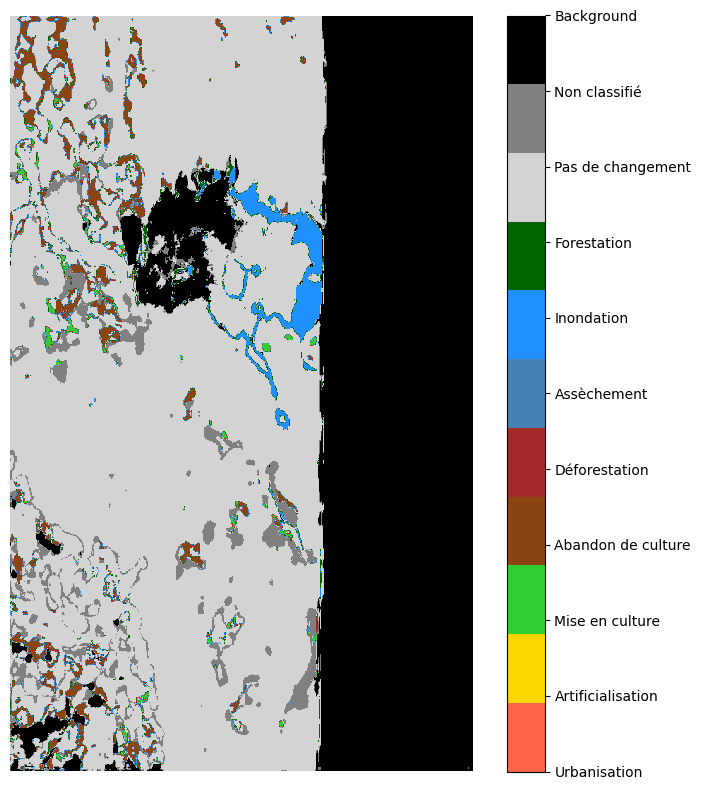

In [15]:
show_image_and_mask(img_path1, mask1, "La région de Ouaoula Année 2017")
show_image_and_mask(img_path2, mask2, "La région de Ouaoula Année 2019")
# ---------- Génération de la carte de changement ----------
change_map = detect_change(mask1, mask2)

# --------------------
change_palette = [
    '#FF6347', '#FFD700', '#32CD32', '#8B4513', '#A52A2A',
    '#4682B4', '#1E90FF', '#006400', 
    '#D3D3D3', '#808080', '#000000',
]
change_names = [
    'Urbanisation', 'Artificialisation', 'Mise en culture', 'Abandon de culture',
    'Déforestation', 'Assèchement', 'Inondation', 'Forestation', 'Pas de changement', 'Non classifié', 'Background',
]
fig, ax = plt.subplots(figsize=(8, 8))
cmap = ListedColormap(change_palette)
cax = ax.imshow(change_map, cmap=cmap, vmin=0, vmax=len(change_palette) - 1)
cbar = fig.colorbar(cax, ax=ax, ticks=np.arange(len(change_names)))
cbar.set_ticklabels(change_names)
ax.axis('off')
plt.tight_layout()
plt.show()

La carte de changement définit les transformations survenues entre les deux cartes d’occupation du sol, en distinguant les différents types de changement.

# Analyse de la carte de changement 

Calcul du pourcentage et de la superficie de chaque type de changement.


 Analyse de la carte de changement :
 Surface totale analysée (hors background) : 70.32 km²

Urbanisation (Arbres → Construit): 0.00 km² (0.00%)
Artificialisation (Cultures → Construit): 0.00 km² (0.00%)
Mise en culture (Sol nu → Cultures): 0.43 km² (0.61%)
Abandon de culture (Cultures → Sol nu): 2.14 km² (3.05%)
Déforestation (Arbres → Cultures): 0.02 km² (0.02%)
Assèchement (Eau → Sol nu): 0.02 km² (0.03%)
Inondation (Sol nu → Eau): 1.11 km² (1.58%)
Forestation (Cultures → Arbres): 0.10 km² (0.14%)
Pas de changement: 38.84 km² (55.23%)
Changement non classifié: 2.40 km² (3.42%)
Background: 25.27 km² (35.93%)


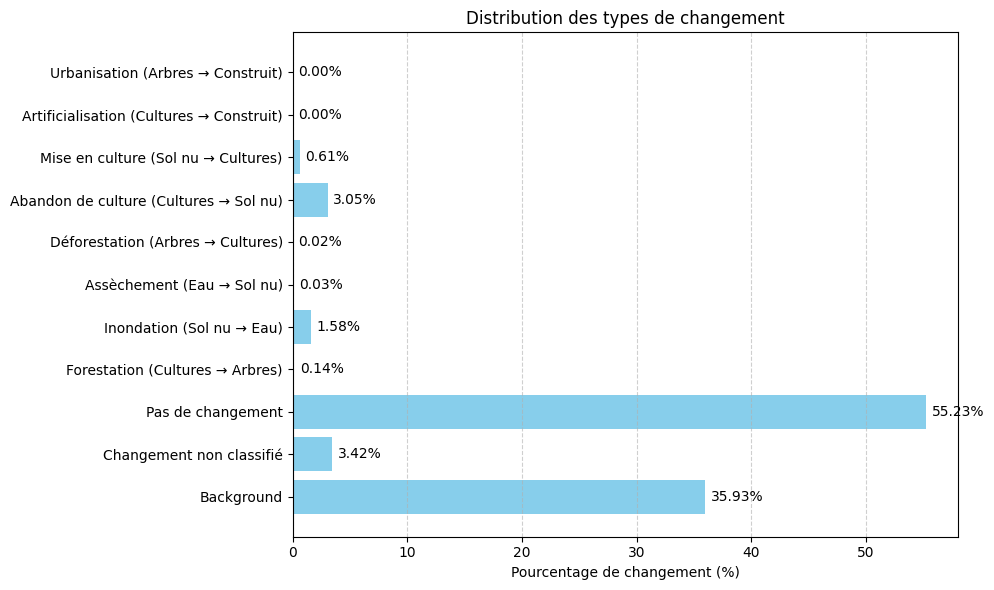

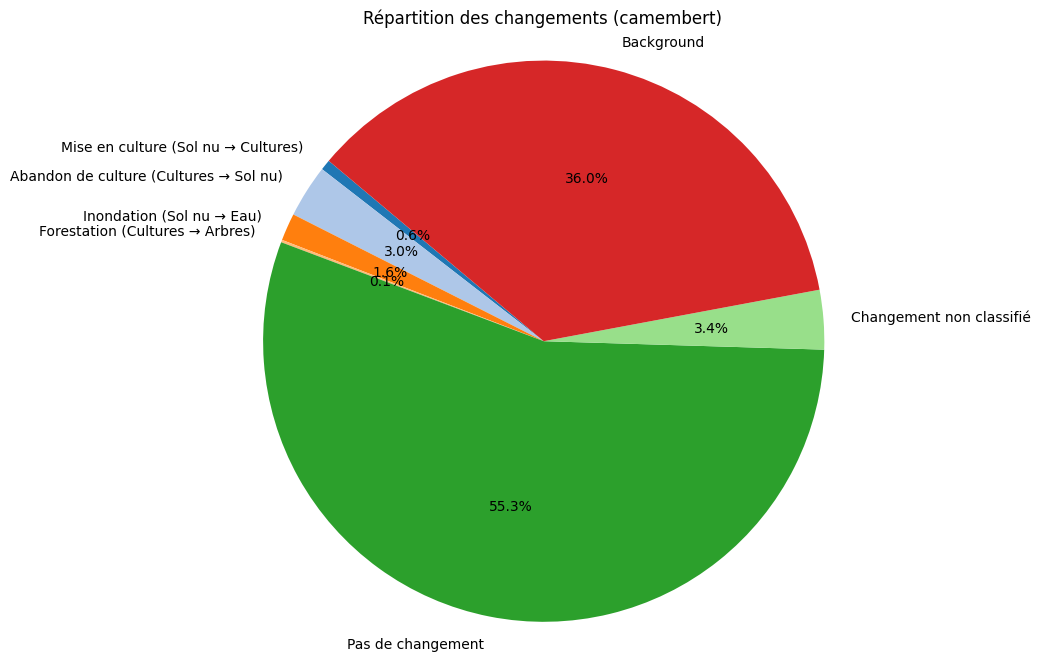

In [16]:
def analyze_change_map(change_map, pixel_size=10):
    change_classes = {
        0: 'Urbanisation (Arbres → Construit)',
        1: 'Artificialisation (Cultures → Construit)',
        2: 'Mise en culture (Sol nu → Cultures)',
        3: 'Abandon de culture (Cultures → Sol nu)',
        4: 'Déforestation (Arbres → Cultures)',
        5: 'Assèchement (Eau → Sol nu)',
        6: 'Inondation (Sol nu → Eau)',
        7: 'Forestation (Cultures → Arbres)',
        8: 'Pas de changement',
        9: 'Changement non classifié',
        10: 'Background'
    }

    # Supprimer le background 
    total_area_pixels = np.count_nonzero(change_map != 12)
    total_area_m2 = total_area_pixels * (pixel_size ** 2)

    change_area = {}
    for class_id, class_name in change_classes.items():
        if class_id != 12:
            class_pixels = np.count_nonzero(change_map == class_id)
            class_area_m2 = class_pixels * (pixel_size ** 2)
            change_area[class_name] = class_area_m2

    # Pourcentage par classe
    change_percentage = {k: (v / total_area_m2) * 100 for k, v in change_area.items()}

    # Affichage des résultats
    print(f"\n Analyse de la carte de changement :")
    print(f" Surface totale analysée (hors background) : {total_area_m2 / 1e6:.2f} km²\n")
    for name, area in change_area.items():
        print(f"{name}: {area / 1e6:.2f} km² ({change_percentage[name]:.2f}%)")

    # ---------- Visualisation (Barres horizontales) ----------
    labels = list(change_percentage.keys())
    values = list(change_percentage.values())

    plt.figure(figsize=(10, 6))
    bars = plt.barh(labels, values, color='skyblue')
    plt.xlabel('Pourcentage de changement (%)')
    plt.title('Distribution des types de changement')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', linestyle='--', alpha=0.6)

    for bar in bars:
        width = bar.get_width()
        plt.text(width + 0.5, bar.get_y() + bar.get_height()/2, f'{width:.2f}%', va='center')

    plt.tight_layout()
    plt.show()

    # ---------- Visualisation (Camembert - facultatif) ----------
    labels_pie = [k for k, v in change_percentage.items() if v > 0.1]
    values_pie = [change_percentage[k] for k in labels_pie]

    if values_pie:
        plt.figure(figsize=(8, 8))
        plt.pie(values_pie, labels=labels_pie, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab20.colors)
        plt.title('Répartition des changements (camembert)')
        plt.axis('equal')
        plt.show()

#la carte finale
analyze_change_map(change_map)


# Comparatif des superficies par classe

In [17]:
def compute_area_table(mask1, mask2, change_map, pixel_size=10):
    class_names = {
         0:"Eau",
         1: "Arbres",
         2: "Herbe",
         3: "Végétation inondée",
         4: "Cultures",
         5: "Arbustes",
         6: "Construit",
         7: "Sol nu",
         8: "Neige / Glace",
         9: "Fond (Background)"
    }

    def area_by_class(mask, name):
        stats = {}
        for class_id, label in class_names.items():
            if class_id == 9:  
                continue
            count = np.count_nonzero(mask == class_id)
            area_m2 = count * pixel_size**2
            stats[label] = area_m2 / 1e6  #  km²
        return pd.Series(stats, name=name)

    df_mask1 = area_by_class(mask1, 'Superficie 2017 (km²)')
    df_mask2 = area_by_class(mask2, 'Superficie 2019 (km²)')
    #df_change = area_by_class(change_map, 'Superficie Changement (km²)')

    df_all = pd.concat([df_mask1, df_mask2], axis=1)
    df_all.index.name = 'Classe'
    df_all = df_all.round(2)
    
    print("\n📋 Tableau comparatif des superficies par classe :")
    display(df_all)  
    return df_all

table = compute_area_table(mask1, mask2, change_map)


📋 Tableau comparatif des superficies par classe :


,Superficie 2017 (km²),Superficie 2019 (km²)
Classe,,
Eau,2.17,3.65
Arbres,0.15,0.41
Herbe,0.00,0.00
Végétation inondée,0.00,0.00
Cultures,3.70,2.06
Arbustes,4.41,6.46
Construit,0.00,0.00
Sol nu,35.37,33.67
Neige / Glace,0.00,0.00
